# Implementation of Piezoelectric Crystals on San Diego Roads
### Names and PIDs:
- Tejas Gopal: A12756764
- David Liau: A12867539
- Vivek Koppuru: A12282018
- Hunter Lai: A12800416
- Yahan Chen: A92156448

## Regarding Introduction, Background and Data Description:
### All background information, introduction to our research question, data description, and further explanation of methods is provided in the project proposal (ProjectProposal.ipynb).

In [1]:
# Imports !

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten

## Part 1: Data Cleaning 

In this first part, we will load all the data from our .csv files into data frames. 
Then, we will perform data cleaning on these data frames, by erasing certain unneeded columns and dropping NaNs.

In [2]:
# Gather data into dataframes

traffic_main_df = pd.read_csv('traffic_counts_datasd.csv')
intersections_df = pd.read_csv('Intersections.csv')
caltrans_df = pd.read_csv('Caltrans.csv')

In [3]:
# Perform data cleaning on the dataframes

# Remove directional columns from traffic_counts
traffic_main_df.drop('id', 1, inplace=True)
traffic_main_df.drop('northbound_count', 1, inplace=True)
traffic_main_df.drop('southbound_count', 1, inplace=True)
traffic_main_df.drop('all_count', 1, inplace=True)
traffic_main_df.drop('eastbound_count', 1, inplace=True)
traffic_main_df.drop('westbound_count', 1, inplace=True)
traffic_main_df.drop('file_no', 1, inplace=True)
traffic_main_df.drop('count_date', 1, inplace=True)

#Drop any rows with NaN values in traffic_main counts
traffic_main_df.dropna(inplace=True) 
traffic_main_df = traffic_main_df[traffic_main_df['total_count'] != 0]

# Printing out a sample (head) of the cleaned traffic_main dataframe (entire roads).
traffic_main_df.head()

,street_name,limits,total_count
0,01 AV,BEECH ST - CEDAR ST,23590
1,01 AV,ELM ST - FIR ST,3530
2,01 AV,ELM ST - FIR ST,4120
3,01 AV,ELM ST - FIR ST,3880
4,01 AV,GRAPE ST - HAWTHORN ST,7330


In [4]:
# Data cleaning on intersections data

intersections_df.drop('Document ID', 1, inplace=True)
intersections_df.drop('Remote ID', 1, inplace=True)
intersections_df.drop('Filename', 1, inplace=True)
intersections_df.drop('Received At', 1, inplace=True)
intersections_df.drop('Processed At', 1, inplace=True)

# Drop any rows with NaN values in traffic_main counts
intersections_df.dropna(inplace=True)

# Clean out new page headers (extracted from PDF)
intersections_df = intersections_df[intersections_df['1st Cross Street'] != '1st Cross Street']

# Clean the traffic count values (get rid of tail symbols e.g. 'N', 'S', etc.)
for index, row in intersections_df.iterrows():
    row['2009'] = row['2009'].split()[0]
    row['2010'] = row['2010'].split()[0]
    row['2011'] = row['2011'].split()[0]
    row['2012'] = row['2012'].split()[0]
    row['2013'] = row['2013'].split()[0]

# Taking the average traffic of all the years (2009 - 2013) and storing it in a column called "Average AADT"
intersections_df['Average AADT'] = 0
for i, row in intersections_df.iterrows():
    avg = int((int(row['2009']) + int(row['2010']) + int(row['2011']) 
                                                    + int(row['2012']) + int(row['2013']))) / 5
    intersections_df.set_value(i, 'Average AADT', avg) 

# Printing out a sample (head) of the cleaned intersections dataframe (intersections).
intersections_df.head()

,Primary Street,1st Cross Street,2nd Cross Street,2009,2010,2011,2012,2013,Average AADT
0,A ST,KETTNER BLVD,INDIA ST,5100,6100,6100,6100,6100,5900
1,A ST,INDIA ST,COLUMBIA ST,7900,6800,6800,6800,6800,7020
2,A ST,COLUMBIA ST,FRONT ST,8700,10100,10100,10100,8800,9560
3,A ST,FRONT ST,1ST AVE,12600,12000,9300,9300,11400,10920
4,A ST,1ST AVE,4TH AVE,11500,10800,10800,10800,10800,10940


In [5]:
# Data cleaning on caltrans dataframe

caltrans_df.drop('Caltrans District ID Number', 1, inplace=True)
caltrans_df.drop('Route Suffix', 1, inplace=True)
caltrans_df.drop('Postmile Prefix', 1, inplace=True)
caltrans_df.drop('Postmile Number', 1, inplace=True)
caltrans_df.drop('Postmile Suffix', 1, inplace=True)
caltrans_df.drop('South or Westbound Peak Hour', 1, inplace=True)
caltrans_df.drop('South or Westbound Peak Month', 1, inplace=True)
caltrans_df.drop('North or Eastbound Peak Hour', 1, inplace=True)
caltrans_df.drop('North or Eastbound Peak Month', 1, inplace=True)


In [6]:
# Retrieve only San Diego county data
caltrans_df = caltrans_df[caltrans_df['County'] == "San Diego"]
caltrans_df = caltrans_df[caltrans_df['Description of Location'].str.contains("JCT.")]

# fill all NaN traffic values (directional) with 0's for average computation
caltrans_df['South or Westbound Annual Average Daily Traffic (AADT)'].fillna(0, inplace=True)
caltrans_df['North or Eastbound Annual Average Daily Traffic (AADT)'].fillna(0, inplace=True)

# append a new column with consolidated directional traffic counts (S/W + N/E)
caltrans_df['Total Average Daily Traffic (TADT)'] = (
    caltrans_df['South or Westbound Annual Average Daily Traffic (AADT)'] +
    caltrans_df['North or Eastbound Annual Average Daily Traffic (AADT)'])

# Printing out a sample (head) of the cleaned caltrans dataframe (highways).
caltrans_df

,Route Number,County,Description of Location,South or Westbound Annual Average Daily Traffic (AADT),North or Eastbound Annual Average Daily Traffic (AADT),Location,Total Average Daily Traffic (TADT)
4526,56,San Diego,JCT. RTE. 5,0.0,57000.0,"(32.93081519, -117.2400333)",57000.0
6041,5,San Diego,SOUTH JCT. RTE. 805,73000.0,37000.0,"(32.5496832, -117.0405826)",110000.0
6044,5,San Diego,"SAN DIEGO, JCT. RTE. 905",65000.0,98000.0,"(32.56526876, -117.073255)",163000.0
6046,5,San Diego,JCT. RTE. 75 WEST,116000.0,148000.0,"(32.58383566, -117.0872501)",264000.0
6053,5,San Diego,JCT. RTE. 54,127000.0,183000.0,"(32.65124908, -117.1041)",310000.0
6058,5,San Diego,JCT. RTE. 15 NORTH,194000.0,157000.0,"(32.69300652, -117.1216583)",351000.0
6060,5,San Diego,"SAN DIEGO, JCT. RTE. 75 SOUTH",161000.0,163000.0,"(32.70153619, -117.1429602)",324000.0
6062,5,San Diego,"SAN DIEGO, JCT. RTE. 94",167000.0,215000.0,"(32.71368958, -117.1475437)",382000.0
6064,5,San Diego,"SAN DIEGO, JCT. RTE. 163",215000.0,206000.0,"(32.72418912, -117.1554495)",421000.0
6073,5,San Diego,JCT. RTE. 8/CAMINO DEL RIO,199000.0,201000.0,"(32.75911385, -117.2037181)",400000.0


In [7]:
# Create a dictionary of street-range locations to total_count
main_dict = dict()
main_counts = dict() # keeps track of # of keys found

for i, row in traffic_main_df.iterrows():
    keytp = (row['street_name'], row['limits'])
    # If key already exists in the dictionary, append to count and take sum of traffic values
    if keytp in main_dict:
        main_counts[keytp] = main_counts[keytp] + 1
        main_dict[keytp] = (main_dict[keytp] + row['total_count'])
    # Otherwise, initialize key to traffic value and count to 1
    else:
        main_counts[keytp] = 1
        main_dict[keytp] = row['total_count']

# Computing final average of all traffic values
for key in main_dict:
    main_dict[key] = main_dict[key] / main_counts[key]

total_traffic = dict()
for key in main_dict:
    street = str(key[0])
    if street in total_traffic.keys():
        total_traffic[street] = total_traffic[street] + main_dict[key]
    else:
        total_traffic[street] = main_dict[key]

total_traffic = {x:y for x,y in total_traffic.items() if y!=0}
        

In [8]:
# Creating dictionary for intersection pairs

inter_dict = dict()

for i, row in intersections_df.iterrows():
    key = (row['Primary Street'], row['1st Cross Street'], row['2nd Cross Street'])
    # Initialize key to intersection value 
    inter_dict[key] = row['Average AADT']

## Data Visualization

We will now be visualizing the spread of data before analyzing it. This way, we can get a better understanding of the distribution of traffic volume in different settings (roads, intersections, or highways). 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013C5B7D8D68>]], dtype=object)

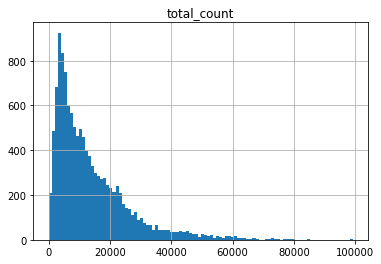

In [9]:
# Data Visualization
traffic_main_df.hist(column='total_count', bins=100)

The above plot shows the total count of all average daily traffic on individual roads. 
As you can see, there is a right skew because most streets have, on average, a smaller amount of traffic.
There are a few roads that do have a large amount of traffic, but the number of those roads are extremely small compared to small amounts of traffic.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013C5AE018D0>]], dtype=object)

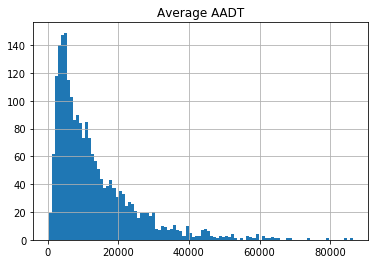

In [10]:
intersections_df.hist(column='Average AADT', bins=100)

Similarly, this plot shows the range of traffic for intersections. Again, the graph is shows a right skew because most intersections have a smaller amount of traffic, while very few intersections have a large amount of traffic.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013C5B40B9E8>]], dtype=object)

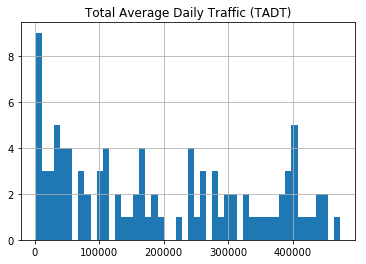

In [11]:
caltrans_df.hist(column='Total Average Daily Traffic (TADT)', bins=50)

Lastly, this graph shows the amount of traffic for highways. Because there are so few highways in San Diego, the frequency of highways will not be very large. However, we a massive increase in traffic compared to those data sets of intersections and roads. 

## Data Analysis: K-Means Clustering

Our first step of analysis is to use K-Means. We aim to separate the data into five distinct groups, each with their own mean traffic volume. This way, we can categorize any road as part of a larger group (e.g. avenues, boulevards, and local roads).

In addition, we can now predict information about a given road based on the cluster it belongs to, such as length, number of lanes, energy generated, cost of implementation, and profit.

For the purposes of our research question, we will be focusing mainly on the amount of energy generated, the cost of implementing crystals on each road, and the total profit to be gained annually.


In [12]:
# K-means clustering to find groups of traffic volumes
# energy generated depends on (worst case, 20 mpg car generates 0.19 MJ by travelling 1 km strip)
# Make a new dataframe joining 

total_traffic
d1 = total_traffic.keys()
d1 = [i for i in range(len(d1))]
d2 = total_traffic.values()
d2 = [int(x) for x in d2]

d1w = whiten(d1)
d2w = whiten(d2)

In [13]:
# Putting data in a numpy array for k-means fit
data = np.vstack([d1w, d2w]).T

In [14]:
# Fitting the data
km = KMeans(n_clusters=5)
km.fit(data)

# Getting a dictionary of the results of each cluster
results = km.predict(data)

# Storing each datapoint in an individual cluster
l1 = list(total_traffic.keys())
clusters = {}
n = 0
for item in results:
    if item in clusters:
        clusters[item].append(l1[n])
    else:
        clusters[item] = [l1[n]]
    n+=1

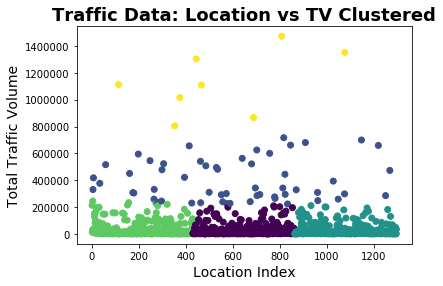

In [15]:
# Let's check out the clusters that KMeans found!!!!
plt.scatter(d1, d2, c=km.labels_);
plt.xlabel('Observation')
plt.ylabel('AADT')

# Add title, labels and legend
plt.title("Traffic Data: Location vs TV Clustered", fontsize=18, fontweight='bold')
plt.xlabel('Location Index', fontsize=14);
plt.ylabel('Total Traffic Volume', fontsize=14);

The above K-means visualization displays five clusters of traffic volumes ranging from large avenues to small, local streets. As you can see, the y-axis represents total traffic volumes on a given x-axis (which represents location index). 

Each cluster is color coded according to its proximity to a certain mean (k-mean), displaying the type of street it corresponds to. This way, we can map out the location space in terms of avenues, boulevards, local streets, etc. 

As you can see, the top cluster consists of locations with large traffic values, which we have verified (more or less using Google maps). This will help us categorize a street based on the cluster it belongs to, as well as retrieve important information regarding said street (including energy gained, money generated, number of lanes, and approximate length of street).

### Key: 
- Top cluster = Largest Avenues
- Middle Cluster = Medium-sized Roads (e.g. Boulevards, Smaller Aves)
- Bottom Clusters = Local Roads & Main Roads

In [16]:
# Construct average traffic volume segments for each of the 5 clusters
map_avgs = dict()
currSum = 0
currCount = 0

for item in clusters:
    
    # We reset current sum and current count for each new cluster
    currSum = 0
    currCount = 0
    for loc in clusters[item]:
        currSum = currSum + total_traffic[loc]
        currCount = currCount + 1
    
    # set dictionary value
    map_avgs[item] = currSum / currCount

In [17]:
# Determine the location closest to the average traffic volume within each cluster:
for item in clusters:
    minDiff = 10000000000000.0
    optLoc = "N/A"
    
    for loc in clusters[item]:
        if (np.fabs(total_traffic[loc] - map_avgs[item]) < minDiff):
            minDiff = np.fabs(total_traffic[loc] - map_avgs[item])
            optLoc = loc
    
    # Printing the result from each cluster 
    print(item) # Index of cluster
    print(optLoc) # Location closest to average
    print(total_traffic[optLoc]) # Traffic Volume at Location
    print(minDiff) # Difference between location's traffic volume and the average of the cluster

3
CATALINA  BL
29046.0
435.033581713
1
SUNSET CLIFFS BL
393416.06666666665
6652.41203692
4
BALBOA AV
1112507.3063492063
17146.6247024
0
HEALTH CENTER DR
26112.0
33.4056067588
2
UTAH ST
24452.833333333332
13.2104549873


In [18]:
# cost per lane per 1 mi * length in miles * number of lanes
def computeCost(miles, lanes):
    return 326095 * miles * lanes;

# amount of energy generated in mJ
def computeEnergy(traffic_volume):
    return 0.305776 * traffic_volume;

# energy in MJ per 20 mpg car over 1 mi * kwh in 1 MJ * cents per kwh in San Diego * number of cars
def computeEnergyInDollars(traffic_volume):
    return 0.305776 * 277.78 * .211 * traffic_volume;

# net gain/loss is (energy's worth in $ - cost of implementation)
def computeSavings(energy, cost):
    return energy - cost;

In [19]:
# Create a dictionary storing information about type of street, optimal location within that category of street, 
# number of lanes approximation, energy generated approximation, and cost approximation

clusters_results = dict()

# Determining energy (in mJ), cost of implementation, expected revenue, and the monetary value of energy for each cluster.

energy_scott = computeEnergy(total_traffic['SCOTT ST'])
energy_rev_scott = computeEnergyInDollars(total_traffic['SCOTT ST'])
cost_scott = computeCost(0.84,1)
savings_scott = computeSavings(energy_rev_scott, cost_scott)

energy_madison = computeEnergy(total_traffic['MADISON AV'])
energy_rev_madison = computeEnergyInDollars(total_traffic['MADISON AV'])
cost_madison = computeCost(1.55,2)
savings_madison = computeSavings(energy_rev_madison, cost_madison)

energy_antigua = computeEnergy(total_traffic['ANTIGUA BL'])
energy_rev_antigua = computeEnergyInDollars(total_traffic['ANTIGUA BL'])
cost_antigua = computeCost(2.04,5)
savings_antigua = computeSavings(energy_rev_antigua, cost_antigua)

energy_euclid = computeEnergy(total_traffic['EUCLID AV'])
energy_rev_euclid = computeEnergyInDollars(total_traffic['EUCLID AV'])
cost_euclid = computeCost(5.80,5)
savings_euclid = computeSavings(energy_rev_euclid, cost_euclid)

energy_balboa = computeEnergy(total_traffic['BALBOA AV'])
energy_rev_balboa = computeEnergyInDollars(total_traffic['BALBOA AV'])
cost_balboa = computeCost(5.92,9)
savings_balboa = computeSavings(energy_rev_balboa, cost_balboa)

clusters_results['Small:1'] = ("Energy Generated = " + str(energy_scott)+ " mJ", "Energy Revenue = $" + str(energy_rev_scott), "Cost = $" + str(cost_scott), "Savings = " + str(savings_scott), 
                               "Length = " + str(0.84), "Number of Lanes = " + str(1))
clusters_results['Small:2'] = ("Energy Generated = " + str(energy_madison)+ " mJ", "Energy Revenue = $" + str(energy_rev_madison), "Cost = $" + str(cost_madison), "Savings = " + str(savings_madison), 
                               "Length = " + str(1.55), "Number of Lanes = " + str(2))
clusters_results['Small:3'] = ("Energy Generated = " + str(energy_antigua)+ " mJ", "Energy Revenue = $" + str(energy_rev_antigua), "Cost = $" + str(cost_antigua), "Savings = " + str(savings_antigua), 
                               "Length = " + str(2.04), "Number of Lanes = " + str(5))
clusters_results['Medium'] = ("Energy Generated = " + str(energy_euclid)+ " mJ", "Energy Revenue = $" + str(energy_rev_euclid), "Cost = $" + str(cost_euclid), "Savings = " + str(savings_euclid), 
                              "Length = " + str(5.80), "Number of Lanes = " + str(5))
clusters_results['Large'] = ("Energy Generated = " + str(energy_balboa)+ " mJ", "Energy Revenue = $" + str(energy_rev_balboa), "Cost = $" + str(cost_balboa), "Savings = " + str(savings_balboa), 
                             "Length = " + str(5.92), "Number of Lanes = " + str(9))

# This is the dictionary of all results for each cluster. We will use this dictionary to make predictions about other roads
# depending on which cluster said road belongs to.
print(clusters_results)

{'Small:1': ('Energy Generated = 7668.89605511111 mJ', 'Energy Revenue = $449486.11464582925', 'Cost = $273919.8', 'Savings = 175566.31464582926', 'Length = 0.84', 'Number of Lanes = 1'), 'Small:2': ('Energy Generated = 8136.943980800001 mJ', 'Energy Revenue = $476919.14308617765', 'Cost = $1010894.5', 'Savings = -533975.3569138224', 'Length = 1.55', 'Number of Lanes = 2'), 'Small:3': ('Energy Generated = 8579.5700296 mJ', 'Energy Revenue = $502862.15515550267', 'Cost = $3326169.0', 'Savings = -2823306.8448444973', 'Length = 2.04', 'Number of Lanes = 5'), 'Medium': ('Energy Generated = 128864.87418866665 mJ', 'Energy Revenue = $7552973.88269897', 'Cost = $9456755.0', 'Savings = -1903781.11730103', 'Length = 5.8', 'Number of Lanes = 5'), 'Large': ('Energy Generated = 340178.0341062349 mJ', 'Energy Revenue = $19938372.060260314', 'Cost = $17374341.599999998', 'Savings = 2564030.4602603167', 'Length = 5.92', 'Number of Lanes = 9')}


In [20]:
# Define function: given any street, let's make predictions on energy, cost, profits, and more!

def getStreetInfo(street_name):
    print("Finding info for " + street_name + "...")
    for item in clusters:
        if street_name in clusters[item] and "SCOTT ST" in clusters[item]:
            print(clusters_results['Small:1'])
        elif street_name in clusters[item] and "MADISON AV" in clusters[item]:
            print(clusters_results["Small:2"])
        elif street_name in clusters[item] and "ANTIGUA BL" in clusters[item]:
            print(clusters_results["Small:3"])
        elif street_name in clusters[item] and "EUCLID AV" in clusters[item]:
            print(clusters_results["Medium"])
        elif street_name in clusters[item] and "BALBOA AV" in clusters[item]:
            print(clusters_results["Large"])
    print("\n")

# These are same roads that we all know and love :)
getStreetInfo("GENESEE AV")
getStreetInfo("CONVOY ST")

# This is a possible edge case in which a street does not exist. Notice that no data is printed.
getStreetInfo("HELLO ST")

Finding info for GENESEE AV...
('Energy Generated = 340178.0341062349 mJ', 'Energy Revenue = $19938372.060260314', 'Cost = $17374341.599999998', 'Savings = 2564030.4602603167', 'Length = 5.92', 'Number of Lanes = 9')


Finding info for CONVOY ST...
('Energy Generated = 8579.5700296 mJ', 'Energy Revenue = $502862.15515550267', 'Cost = $3326169.0', 'Savings = -2823306.8448444973', 'Length = 2.04', 'Number of Lanes = 5')


Finding info for HELLO ST...




## Data Analysis Part 2: Top 10 Intersection Segments!

In this section, we will take the top 10 streets (as in, the top 10 intersections with the most traffic volume), 
and determine the total cost to implement the piezoelectric crystals on the street, the amount of energy gained from this
implementation, and the total amount of profit yearly.

This is our approach to determining *OPTIMAL* locations to place the sensors.

In [21]:
# First, find the top 10 segments by traffic volume and store into a list.
top10 = sorted(inter_dict, key=inter_dict.get, reverse=True)[:10]

In [22]:
# Printing out the information of the top 10 results.
# The data is as follows: Primary Road, First Cross Street, Second Cross Street, Total Traffic Volume.
top10info = {}
for i in top10:
    top10info[i] = [i, inter_dict[i]]
    print(top10info[i])

[('FAIRMOUNT AVE', 'INTERSTATE 8', 'CAMINO DEL RIO SOUTH'), 86400]
[('NORTH HARBOR DR', 'WINSHIP LN', 'LAUREL ST'), 84400]
[('CORONADO BRIDGE/ROUTE', '75 INTERSTATE 5', 'CITY LIMITS'), 79100]
[('MIRA MESA BLVD', 'WESTVIEW PKWY', 'INTERSTATE 15'), 74200]
[('FAIRMOUNT AVE', 'CAMINO DEL RIO SOUTH', 'MONTEZUMA RD'), 68860]
[('WEST MISSION BAY DR', 'INGRAHAM ST', 'SEA WORLD DR'), 67620]
[('MIRA MESA BLVD', 'BLACK MOUNTAIN DR', 'WESTVIEW PKWY'), 65000]
[('PALM AVE/ROUTE 75', 'SATURN BLVD', 'INTERSTATE 5'), 64040]
[('MIRAMAR RD', 'CAMINO RUIZ', 'BLACK MOUNTAIN RD'), 63940]
[('MIRAMAR RD', 'NOBEL DR', 'EASTGATE MALL'), 63380]


In [23]:
# Manual entries of segment length in miles and average estimate of number of lanes in segment
# When doing calculations, could also normalize all of these with 1 mile and see how the costs and stuff look like with 
#   amount of cars and lanes

# Note: We used Google Maps visualization to approximate the length and number of lanes of each location.
# Then, we append the number of lanes and length of road to each entry of the list.


top10info[('FAIRMOUNT AVE', 'INTERSTATE 8', 'CAMINO DEL RIO SOUTH')].append(0.3)
top10info[('FAIRMOUNT AVE', 'INTERSTATE 8', 'CAMINO DEL RIO SOUTH')].append(6)

top10info[('NORTH HARBOR DR', 'WINSHIP LN', 'LAUREL ST')].append(0.7)
top10info[('NORTH HARBOR DR', 'WINSHIP LN', 'LAUREL ST')].append(7)

top10info[('CORONADO BRIDGE/ROUTE', '75 INTERSTATE 5', 'CITY LIMITS')].append(2.1)
top10info[('CORONADO BRIDGE/ROUTE', '75 INTERSTATE 5', 'CITY LIMITS')].append(5)

top10info[('MIRA MESA BLVD', 'WESTVIEW PKWY', 'INTERSTATE 15')].append(0.2)
top10info[('MIRA MESA BLVD', 'WESTVIEW PKWY', 'INTERSTATE 15')].append(9)

top10info[('FAIRMOUNT AVE', 'CAMINO DEL RIO SOUTH', 'MONTEZUMA RD')].append(0.3)
top10info[('FAIRMOUNT AVE', 'CAMINO DEL RIO SOUTH', 'MONTEZUMA RD')].append(6)

top10info[('WEST MISSION BAY DR', 'INGRAHAM ST', 'SEA WORLD DR')].append(0.3)
top10info[('WEST MISSION BAY DR', 'INGRAHAM ST', 'SEA WORLD DR')].append(6)

top10info[('MIRA MESA BLVD', 'BLACK MOUNTAIN DR', 'WESTVIEW PKWY')].append(0.3)
top10info[('MIRA MESA BLVD', 'BLACK MOUNTAIN DR', 'WESTVIEW PKWY')].append(7)

top10info[('PALM AVE/ROUTE 75', 'SATURN BLVD', 'INTERSTATE 5')].append(0.3)
top10info[('PALM AVE/ROUTE 75', 'SATURN BLVD', 'INTERSTATE 5')].append(6)

top10info[('MIRAMAR RD', 'CAMINO RUIZ', 'BLACK MOUNTAIN RD')].append(0.8)
top10info[('MIRAMAR RD', 'CAMINO RUIZ', 'BLACK MOUNTAIN RD')].append(6)

top10info[('MIRAMAR RD', 'NOBEL DR', 'EASTGATE MALL')].append(0.3)
top10info[('MIRAMAR RD', 'NOBEL DR', 'EASTGATE MALL')].append(7)

print(top10info)

{('FAIRMOUNT AVE', 'INTERSTATE 8', 'CAMINO DEL RIO SOUTH'): [('FAIRMOUNT AVE', 'INTERSTATE 8', 'CAMINO DEL RIO SOUTH'), 86400, 0.3, 6], ('NORTH HARBOR DR', 'WINSHIP LN', 'LAUREL ST'): [('NORTH HARBOR DR', 'WINSHIP LN', 'LAUREL ST'), 84400, 0.7, 7], ('CORONADO BRIDGE/ROUTE', '75 INTERSTATE 5', 'CITY LIMITS'): [('CORONADO BRIDGE/ROUTE', '75 INTERSTATE 5', 'CITY LIMITS'), 79100, 2.1, 5], ('MIRA MESA BLVD', 'WESTVIEW PKWY', 'INTERSTATE 15'): [('MIRA MESA BLVD', 'WESTVIEW PKWY', 'INTERSTATE 15'), 74200, 0.2, 9], ('FAIRMOUNT AVE', 'CAMINO DEL RIO SOUTH', 'MONTEZUMA RD'): [('FAIRMOUNT AVE', 'CAMINO DEL RIO SOUTH', 'MONTEZUMA RD'), 68860, 0.3, 6], ('WEST MISSION BAY DR', 'INGRAHAM ST', 'SEA WORLD DR'): [('WEST MISSION BAY DR', 'INGRAHAM ST', 'SEA WORLD DR'), 67620, 0.3, 6], ('MIRA MESA BLVD', 'BLACK MOUNTAIN DR', 'WESTVIEW PKWY'): [('MIRA MESA BLVD', 'BLACK MOUNTAIN DR', 'WESTVIEW PKWY'), 65000, 0.3, 7], ('PALM AVE/ROUTE 75', 'SATURN BLVD', 'INTERSTATE 5'): [('PALM AVE/ROUTE 75', 'SATURN BLVD'

In [24]:
# Determining the top 10 cost for each entry in the list. We get the equation from our reference papers (see proposal).
top10cost = {}
for i in top10info:
    # cost per lane per 1 mi * length in miles * number of lanes
    top10cost[i] = 326095 * top10info[i][2] * top10info[i][3]
    print(top10cost[i])

586971.0
1597865.5
3423997.5
586971.0
586971.0
586971.0
684799.5
586971.0
1565256.0
684799.5


In [25]:
# Determining the top 10 monetary value of energy for each entry in the list.
# We get the equation from our reference papers (see proposal).
top10energy = {}
for i in top10info:
    # energy in MJ per 20 mpg car over 1 mi * kwh in 1 MJ * cents per kwh in San Diego * number of cars
    top10energy[i] = 0.305776 * 277.78 * .211 * top10info[i][1]
    print(top10energy[i])

1548462.0515973119
1512618.0226251518
1417631.345848928
1329813.474867136
1234109.9175114688
1211886.6195487294
1164930.9415952
1147725.8076885631
1145933.6062399552
1135897.2781277504


In [26]:
# Determining the top 10 savings for each entry in the list. We get the equation from our reference papers (see proposal).
top10savings = {}
for i in top10info:
    # cost of energy generated - cost of constructing
    top10savings[i] = top10energy[i] - top10cost[i]
    print(top10savings[i])

961491.0515973119
-85247.47737484821
-2006366.154151072
742842.474867136
647138.9175114688
624915.6195487294
480131.4415952
560754.8076885631
-419322.3937600448
451097.7781277504


In [27]:
# Constructing a list of results with every field for each entry.
top10results = []
for i in range(0, 10):
    top10results.append([top10[i], top10cost[top10[i]], top10energy[top10[i]], top10savings[top10[i]]])

In [28]:
# Displaying segment, cost of building, energy generated cost, savings for each of the top 10 locations.
for i in top10results:
    print(i)

[('FAIRMOUNT AVE', 'INTERSTATE 8', 'CAMINO DEL RIO SOUTH'), 586971.0, 1548462.0515973119, 961491.0515973119]
[('NORTH HARBOR DR', 'WINSHIP LN', 'LAUREL ST'), 1597865.5, 1512618.0226251518, -85247.47737484821]
[('CORONADO BRIDGE/ROUTE', '75 INTERSTATE 5', 'CITY LIMITS'), 3423997.5, 1417631.345848928, -2006366.154151072]
[('MIRA MESA BLVD', 'WESTVIEW PKWY', 'INTERSTATE 15'), 586971.0, 1329813.474867136, 742842.474867136]
[('FAIRMOUNT AVE', 'CAMINO DEL RIO SOUTH', 'MONTEZUMA RD'), 586971.0, 1234109.9175114688, 647138.9175114688]
[('WEST MISSION BAY DR', 'INGRAHAM ST', 'SEA WORLD DR'), 586971.0, 1211886.6195487294, 624915.6195487294]
[('MIRA MESA BLVD', 'BLACK MOUNTAIN DR', 'WESTVIEW PKWY'), 684799.5, 1164930.9415952, 480131.4415952]
[('PALM AVE/ROUTE 75', 'SATURN BLVD', 'INTERSTATE 5'), 586971.0, 1147725.8076885631, 560754.8076885631]
[('MIRAMAR RD', 'CAMINO RUIZ', 'BLACK MOUNTAIN RD'), 1565256.0, 1145933.6062399552, -419322.3937600448]
[('MIRAMAR RD', 'NOBEL DR', 'EASTGATE MALL'), 684799

## Data Analysis Part 3: Profit Models

Finally, we attempt to predict the expected profit gained by placing a piezoelectric crystal on a particular street using our
cluster-analysis dictionary. Then, we plot a linear model that displays the total amount of profit gained over the following
years.

Keep in mind that this is an approximation that does not account for other factors, such as wear and tear, cost of infrastructure, economic resources, and delay during construction. Refer to further pitfalls in the proposal.

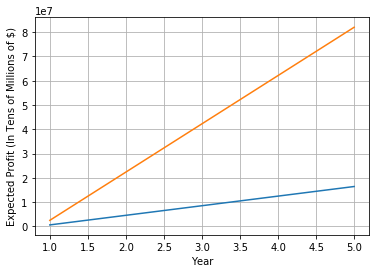

In [29]:
# profit models for any street, avenue, blvd, etc, NOT accounting for infrastructure costs, economic resources, and
# wear and tear.

def computeProfit(street_name):
    for item in clusters:
        if street_name in clusters[item] and "SCOTT ST" in clusters[item]:
            createModel(total_traffic[street_name], 0.84, 1)
        elif street_name in clusters[item] and "MADISON AV" in clusters[item]:
            createModel(total_traffic[street_name], 1.55, 2)
        elif street_name in clusters[item] and "ANTIGUA BL" in clusters[item]:
            createModel(total_traffic[street_name], 2.04, 5)
        elif street_name in clusters[item] and "EUCLID AV" in clusters[item]:
            createModel(total_traffic[street_name], 5.80, 5)
        elif street_name in clusters[item] and "BALBOA AV" in clusters[item]:
            createModel(total_traffic[street_name], 5.92, 9)
            
def createModel(total_traffic, miles, lanes):
    year = []
    profit = []
    for i in range(1, 6):
        year.append(i)
        profit.append(computeEnergyInDollars(total_traffic) * i - computeCost(miles, lanes))
        
    plt.plot(year, profit)
    plt.grid(True)
    plt.xlabel("Year")
    plt.ylabel("Expected Profit (In Tens of Millions of $)")

# Printing sample data. Convoy street has a lower slope, while Genesee clearly generates much more profit over time.
computeProfit("CONVOY ST")
computeProfit("GENESEE AV")

## Conclusions/Discussion

Now we directly address our hypothesis. Recall that our hypothesis was the following statement:
    "We believe the optimal locations to place the piezoelectric crystals will be in areas of high traffic volume, specifically in dense intersections as opposed to entire lengths of roads. We believe we can predict information about a specific road by comparing its characteristics (length, number of lanes, traffic volume) to the optimal locations we find."

For convenience's sake, we will be splitting our answers into two parts, matching the two parts of the hypothesis.

##### Part 1: Optimal Locations to Place Crystals
From our analysis on each data set, we find that even though some areas may have high traffic volume, they may not be the most optimal locations to place the piezoelectric crystals. Several of these reasons may stem from the following: the number of lanes that the area has, or the length of the road. An example of this is in the Coronado Bridge: while its annual traffic volume is larger than most, it will ultimately cost the city of San Diego more than $2 million dollars in a single year because of its short length. This result will change over time, because there are fixed costs (i.e. implementation) in the first year.

However, from our cluster analysis, areas belonging to the top cluster (i.e. with the most amount of traffic) generated the most amount of profit. An example of this is Genesse Avenue, which could make a potential profit over over $80 million over 5 years (of course, not including the costs mentioned prviously).

Possible errors in our first answer may stem from potential pitfalls in our methods. For example, we only considered individual segments of roads in our cost implementation, instead of the entire length of the road (which we used for our cluster analysis). In addition, our energy equation was linear, excluding many of the potential factors that may affect our overall cost-benefit output.

##### Part 2: Making Predictions 
We believe that our clustering analysis developed a pretty accurate model for predicting a road's characteristics given the placement of piezoelectric crystals on that road. We were able to clearly identify specific types of roads by clustering based on traffic volume, and found that most roads within each cluster had very similar statistics. To verify this, we used Google Maps and searched up a few street images, confirming the number of lanes, or length of the street. 

Similar to part 1, we found that implementing the crystals on large avenues compared to boulevards and smaller avenues produced a higher net profit. In addition, we identified a few smaller streets that had the potential to have a very high return on investment.

Possible errors in this analysis were as follows: allowing only five clusters in our data set prevented a more specific analysis of the given data. In addition, we realized that it may be a stretch to predict the length of the road specifically using Google Maps.

#### Thank you for considering our project, and we hope this analysis may serve to benefit the city of San Diego!!

#### Regards, 
#### David Liau, Tejas Gopal, Hunter Lai, Ya-han Chen, and Vivek Koppuru